# Image Reduction Module

**Lecturer:** Dan Perley<br>
**Jupyter Notebook Authors:** Dan Perley, Kishalay De & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2020.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2020.html

## Objective
Process raw images from a visible wavelength telescope and make them ready for photometric analysis

## Key steps
- Reduce raw images by applying biases & flats
- Align and combine consecutive images

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>` (or `pip3 install <module>`).  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* matplotlib
* photutils
* pyregion

### External packages
* SExtractor https://www.astromatic.net/software
* SWarp https://www.astromatic.net/software (optional)


***

## Setup

### Import modules

In [1]:
## Import necessary modules 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import glob
import os
import subprocess
import warnings
import numpy as np
import matplotlib.pyplot as plt
import photutils
import pyregion

# You can ignore any warnings that appear below, but if any modules can't be imported you need to install them

### Test dependencies

In order to complete the module some external software is required.  The following step checks that these are installed properly.

In [2]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('sextractor', 'sex'), ('SWarp', 'swarp')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")        

sextractor is installed properly as sextractor. OK
SWarp is installed properly as SWarp. OK
2 out of 2 external dependencies installed properly.

You are ready to continue.


SWarp and SExtractor are needed only for the second half of the module.  If you are unable to install these packages, it is possible to follow most of the module without them.  If they are installed under a command other than "sextractor" and "SWarp", respectively, you will have to slightly modify some of the example code blocks below.

### Define where data live

The various directories where data live are defined here for use later in this notebook.

In [3]:
## Define data directories

curpath = os.path.abspath('.')                    # top level directory
dataFolder = os.path.join(curpath, 'data')        # data directory
biasFolder = os.path.join(dataFolder, 'bias')     # bias frames subdirectory
flatFolder = os.path.join(dataFolder, 'flat')     # flat fields subdirectory
sciFolder = os.path.join(dataFolder, 'science')   # science data subdirectory
procFolder = os.path.join(curpath, 'processing')  # processing directory
if not os.path.isdir(procFolder): 
    os.mkdir(procFolder)
else:
    for f in os.listdir(procFolder):
        try:
            os.remove(os.path.join(procFolder,f)) # clear the processing folder from previous iterations
        except:
            print('Could not remove',f)

Next we get lists of all the various file types, including lists and names of files we'll be writing out later.

In [4]:
## Get file lists

os.chdir(sciFolder)
fileList = sorted(glob.glob('*.fits'))
os.chdir(curpath)
biasList = sorted(glob.glob(os.path.join(biasFolder,'*.fits')))
flatList = sorted(glob.glob(os.path.join(flatFolder,'*.fits')))
sciList = [os.path.join(sciFolder, file) for file in fileList]
procList = [os.path.join(procFolder, file).replace('.fits','.proc.fits') for file in fileList]
combinedFile = os.path.join(procFolder, 'AT2018cow_combined.fits')
weightFile = os.path.join(procFolder, 'AT2018cow_weight.fits')
resampledFile = os.path.join(procFolder, 'AT2018cow_resampled.fits')

print('Found',len(biasList),'bias files; ',len(flatList),'flat files; ',len(sciList),'science files')


Found 5 bias files;  5 flat files;  3 science files


For this module we will turn off python warnings, since the properties of the files we'll be using tend to generate quite a few spurious warnings messages that would distract from the content of the module.  In general it's better to turn off warnings more selectively only for sections that require it, but hiding warnings globally makes the code a little simpler to read.

In [5]:
warnings.filterwarnings("ignore")

***

## Preliminary Data Inspection and Exploration

Like nearly all astronomical images, our data are stored in the form of FITS files.   FITS files contain a plaintext header storing the observational metadata (e.g. the name of the telescope) plus an array of pixel data.  FITS files can may be 'simple' (single header, single pixel image) or may contain extensions (additional headers and/or pixel images).  

FITS files are loaded and examined using the astropy library in python.  Below we open up a FITS file and take a look at its structure.

In [6]:
## Open an example FITS file

exampleFile = sciList[0]         # The first science image
HDUList = fits.open(exampleFile) # Open the file
HDUList.info()                   # Print some information about the FITS file structure.  

Filename: /home/dperley/growth/image_reduction/data/science/acam761.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  extension1    1 ImageHDU        49   (2148, 2501)   int16 (rescales to uint16)   


This reveals that the FITS header metadata is in extension 0 (the 'primary' header) and the pixel data is in extension 1.  The image dimensions are 2148x2501 pixels.


### Investigate the header

A good FITS header will contain almost everything we need to know about the observation.  Header data is stored as keyword + value pairs, optionally with a comment following the value.  Keywords are all-capitals and 8 characters or less; corresponding values can be much longer.  There is almost no standardization in the use of keywords at different telescopes, but OBJECT and EXPTIME are commonly used to store the name of the object being observed and the integration time in seconds, respectively.

Below we will load the header and print out a limited set of the header lines in "raw" format (showing how the header metadata is stored in the file), and also look up a few specific bits of information using their keywords.

In [7]:
## Print some header properties

header = HDUList[0].header # Get the header out of the HDU list.
print(repr(header[0:13]))  # Print the first 14 lines of the header (in raw format).
print(repr(header[24:34])) # Print some additional lines
print(repr(header[48:52])) 
print(repr(header[67:71])) 
print(repr(header[129:135])) 
print()
print('The object is:', header['OBJECT'])   # Print the name of the object being observed
print('The filters are:', header['ACAMFILT']) # Print the names of the optical filters in the light path.
print('The exposure time is:', header['EXPTIME'])  # Print the exposure time

SIMPLE  =                    T /                                                
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T / File contains extensions                       
RUN     =              2696761 / Run number                                     
IRAFNAME= 'r2696761          ' / IRAF should use this name                      
RUNSET  = '1:1:2696761       ' / i:n:r => Run i of n runs starting at #r        
SYSVER  = 'S15-281           ' / Version of observing system                    
ORIGIN  = 'ING La Palma      ' / Name of observatory                            
OBSERVAT= 'LAPALMA           ' / Name of observatory (IRAF style)               
OBSERVER= 'Dan Perley        ' / Name of principal investigator                 
PROPOSAL= 'P12               ' / Code for grant of observing time               
OBJECT  = 'AT2018cow 0.0 0.0

From this we can infer that this is a Sloan g-band image of AT2018cow and the exposure time was 90 seconds.  We can also see that this data was taken with the ACAM instrument on the WHT last July 14th (by your module leader).  This is only a select portion of the header; printing out the entire header would show other keywords relating to the detector settings and temperature and other properties of the instrument, telescope, and/or facililty.

### Examine the data

It's usually also a good idea to visually inspect the data to get a feel for its appearance and to make sure it doesn't have any obvious problems before we analyze it.  We will use the imshow command within pyplot, which requires us to provide some parameters defining the minimum and maximum range of the colorbar scale.  For this, we will use sigma-clipped image pixel statistics to come up with some reasonable values.

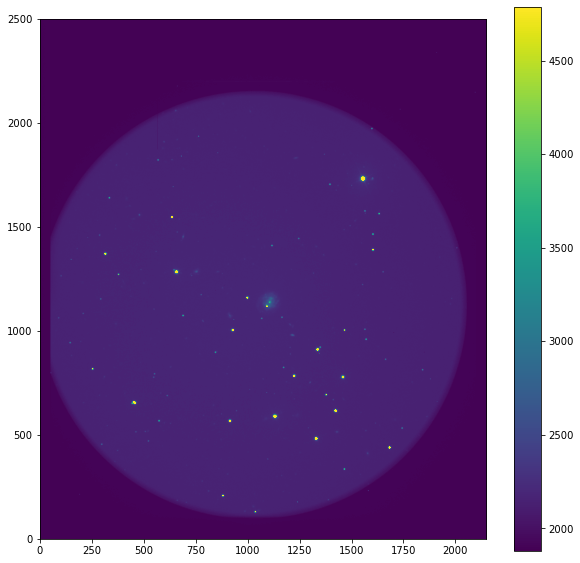

In [8]:
## Get and display the image data

data = HDUList[1].data  # Get the data array (a simple numpy array) from the first extension.

mean, median, std = sigma_clipped_stats(data) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()

This shows us that the field of view of the instrument is circular and centered at approximately x=1000, y=1100.  A significant fraction of the CCD is not exposed, which is important to make note of - the image statistics we calculated earlier include a very large number of blank pixels, a problem that not even sigma clipping can solve.  It would be better to use a subset of the image without any unexposed pixels.

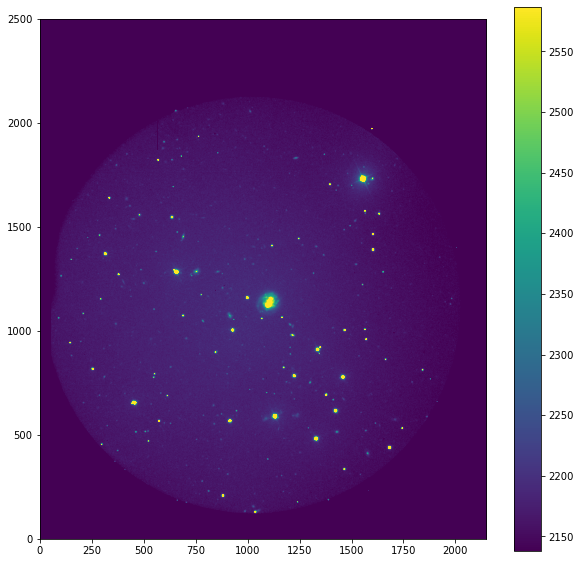

In [9]:
mean, median, std = sigma_clipped_stats(data[500:1600,500:1600]) # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 20*std, origin='lower')
plt.colorbar()
plt.show()

At this stretch some of the issues with the data are more obvious: the background seems to vary due to varying sensitivity across the field, there are some dark spots on the detector, and even the unexposed pixels have a quite large ADU count of around 2150.  Correcting or removing these effects to produce a "pure" image of the night sky is the role of data reduction.  There are two generic steps (bias correction and flat-fielding), which can be followed by a variety of possible high-level calibration and artifact-correction steps.  We will address these in the next section.  For now, we are done inspecting the science image so we will close it.

In [10]:
HDUList.close()                  # Close the file (good practice, but not strictly necessary)

***

## Creating a bias frame

The detector image comes with an electronic offset introduced by the voltages applied to the amplifier.   This can be clearly seen in the science image above: even the unexposed parts of the detector have an apparent signal level of about 1900 counts.  We have to remove this offset to get real counts received by the detector. 

Different bias-removal methods are employed by different detectors.  In most cases, we record a set of images ("bias frames") with zero exposure time, so that the recorded image reflects *only* the intrinsic offsets in the detector (the detector does not receive any photons if the exposure time is zero).  To reduce detector noise and to remove cosmic ray contamination, we usually take many bias frames and average them together using median-combination.  (Even though the exposure time is zero, cosmic rays can strike the detector during readout.)

### Investigate the data

As always, it's a good idea to inspect your images before you process them.  During the first <font color='red'>breakout segment</font>, open the first bias image and verify that it doesn't contain any obvious astronomical signals.

#### Exercise 1: Open and display the first bias image, and determine its median and clipped standard deviation.

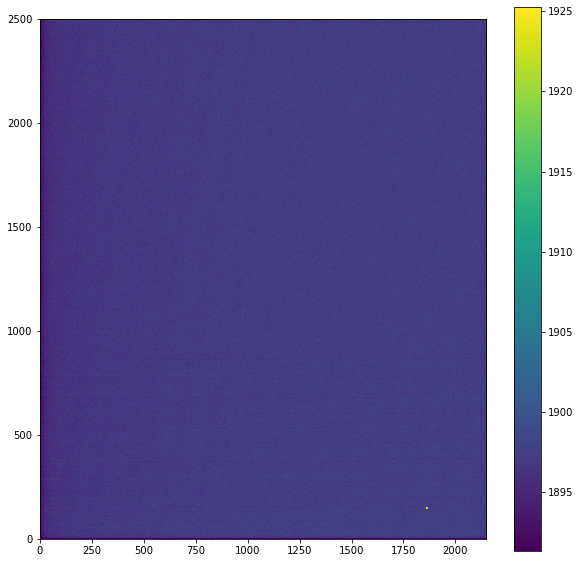

Median: 1897.0
Standard deviation: 2.8254707076165957


In [11]:
## EXERCISE 1:  Display the first bias image and determine its clipped standard deviation.

biasFile = biasList[0]        # The first science image
HDUList = fits.open(biasFile) # Open the file
data = HDUList[1].data   # Get the data array (a simple numpy array) from the first extension.
HDUList.close()          # File can be closed as soon as the data is copied out of it.

mean, median, std = sigma_clipped_stats(data)   # get some image statistics
plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 2*std, vmax = median + 10*std, origin='lower')
plt.colorbar()
plt.show()

print('Median:', median)
print('Standard deviation:', std)


You should see a largely empty image with a hint of structure (faint diagonal and horizontal lines, and lower counts towards the edges), with a blip in the lower right corner (most likely caused by a cosmic ray hitting the detector during readout).  <font color='red'>*You can return from the breakout room once you've produced this, or when time is up.*</font>

### Median-combine the bias images

This process could be repeated with the other four images (in Python or using external software like DS9), but we'll trust the data for now and proceed to the next step, which is to combine all five bias frames together.  To do this, we set up a 3D numpy array and put a bias frame in each layer, and then median-combine along the 3rd dimension to produce a single, median-combined image (our "master bias").

In [12]:
## Median-combine the bias frames to make a master bias

# Create a 3D array to store all the bias files together.
ny = 2501
nx = 2148
numBiasFiles = len(biasList)
biasImages = np.zeros((ny, nx, numBiasFiles))

# Add the files to the array
for i in range(numBiasFiles):
        HDUList = fits.open(biasList[i])     # Open the file
        biasImages[:,:,i] = HDUList[1].data  # Load the data into the appropriate layer
        HDUList.close()                      # Close the file

# Create the master bias frame by doing a median combination for each pixel over all layers
masterBias = np.median(biasImages, axis=2)


#### Exercise 2: Display the master bias image and check that the noise is reduced compared to a single bias frame by calculating and printing out its (sigma-clipped) standard deviation.

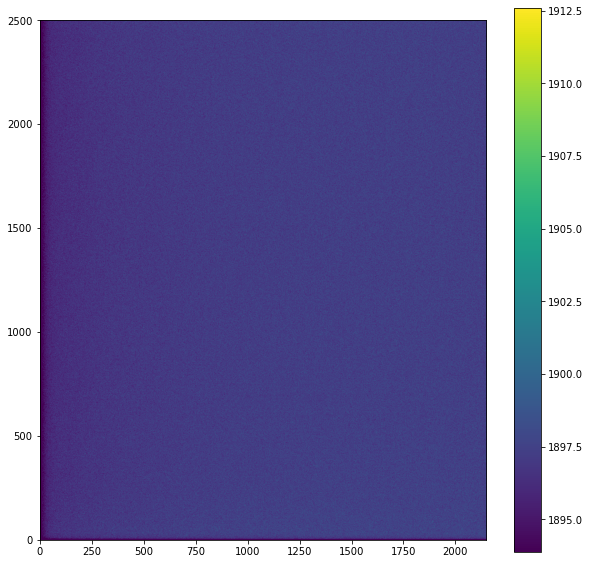

Median: 1897.0
Standard deviation: 1.5592892457878413


In [13]:
## EXERCISE 2:  Display the master bias image and calculate its median and clipped standard deviation.

mean, median, std = sigma_clipped_stats(masterBias) # get some image statistics

plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(masterBias, vmin = median - 2*std, vmax = median + 10*std, origin='lower')
plt.colorbar()
plt.show()

print('Median:', median)
print('Standard deviation:', std)


It should look pretty similar to the individual bias frame, but with lower noise.  Read noise is generally negligible compared to the sky noise for broadband imaging observations such as this one, so this isn't a major consideration here.  However, for narrowband observations or for spectroscopy this may not be the case, so it's always a good idea to take many bias frames if possible.

***

## Creating a flat field

The image recorded on the detector $I(x,y)$ is a product of the true brightness distribution on the sky $S(x,y)$ and the response of the telescope optics and detector in different parts of the image $F(x,y)$. with any bias signal added: i.e.: 

$I(x,y) = F(x,y) S(x,y) + B(x,y)$.  

We already have $B(x,y)$ thanks to our bias frames, but we also need to determine $F(x,y)$ to reconstruct $S(x,y)$.

To do this, we expose the detector to a uniform light source -- this can either be a uniformly illuminated part of the telescope dome or the twilight sky (the assumption is that the sky is uniformly bright over a small field of view).

### Investigate the data

As usual it's good to start by looking at the data.  During the second <font color='red'>breakout segment</font> you will visually examine the first image and print out a few basic properties for the remaining images.

#### Exercise 3: Open and display the first flat-field image.

32075.1818634634 32135.0 936.119619313351


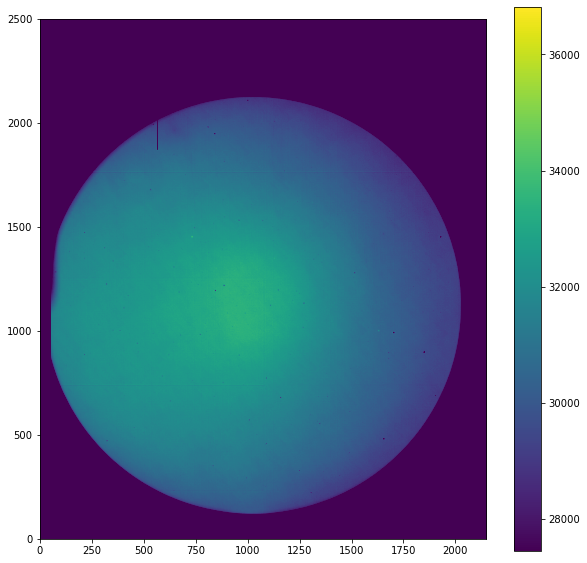

In [14]:
## EXERCISE 3:  Display the first flat-field image.  

flatFile = flatList[0]        # The first flat image
HDUList = fits.open(flatFile) # Open the file
data = HDUList[1].data        # Get the data array (a simple numpy array) from the first extension.
HDUList.close()

mean, median, std = sigma_clipped_stats(data[500:1600,500:1600]) # get some image statistics for exposed pixels
print(mean, median, std)

plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(data, vmin = median - 5*std, vmax = median + 5*std, origin='lower')
plt.colorbar()
plt.show()


You should see the circular field of view of the instrument with no sources discernable within, but some apparent structure with significantly higher counts in the middle than towards the edges.  You will likely want to play around with the "vmin" and "vmax" values a bit to see this structure.  Once you see this, please continue to the next exercise.

It's a good idea to scan through all the flat-field files to make sure that the configuration is what we expect (e.g. the filter didn't change) and that the frames aren't saturated.  In the next exercise you will write a loop to do this check.

#### Exercise 4: Verify that all five flat-field images are acceptable by looping over each file and printing out the filter (ACAMFILT keyword), the exposure time (EXPTIME keyword), and the median pixel value (calculated from the data).

In [15]:
## EXERCISE 4: Verify that all five flat-field images are acceptable by printing out some basic properties.

for fileName in flatList:
    HDUList = fits.open(fileName)
    header = HDUList[0].header # Get the header out of the HDU list.
    data = HDUList[1].data
    median = np.median(data[500:1600,500:1600])
    print(header['ACAMFILT'], header['EXPTIME'], median)
    HDUList.close()


SlnG+CLEAR 9.96 32134.0
SlnG+CLEAR 8.61 32171.0
SlnG+CLEAR 7.44 31967.0
SlnG+CLEAR 6.47 32072.0
SlnG+CLEAR 5.61 31995.0


Your output should confirm that all images are in the same filter and have median count values well below the saturation level of about 63500 (65535-2000, or 2^16 minus the bias value that was subtracted off earlier).  <font color='red'>*You can return from the breakout room once you've confirmed that this is the case.*</font>  Note that the exposure times differ - why might this be the case?

### Normalize and combine flat-fields

The master flat field is formed by median combination in a similar way to the master bias frame, above.  There are two big differences.  First, we have to remove the bias from each image.  Second, we have to adjust for the fact that the light level may be changing from image to image by measuring the average pixel level in each image and dividing the image by it (normalizing).

It is important that this normalization level be calculated only with pixels for which there is actually some signal.  For this camera much of the CCD is unused and has no signal, so we will use a square subset of the image and calculate its median.  Then we divide by this factor and stick it into the appropriate layer of a 3D array.  The median combination at the end is left an an exercise for you.

In [16]:
## Load and normalize the flat fields in preparation for making a master flat field.

# Set up the 3D array
numFlatFiles = len(flatList)
flatImages = np.zeros((ny, nx, numFlatFiles))

# Load the files into the array, with bias subtraction and normalization
for i in range(numFlatFiles):
        # Load the data from the fits file
        HDUList = fits.open(flatList[i])
        data = HDUList[1].data * 1. # Convert to floating point
        HDUList.close()

        # Bias-subtract, normalize, and add to the array layer
        data -= masterBias
        normfactor = np.median(data[500:1600,500:1600])
        print(normfactor)
        flatImages[:,:,i] = data / normfactor


30237.0
30274.0
30070.0
30175.0
30097.0


#### Exercise 5: Perform the median combination to produce a 2D array called masterFlat, and display it. (Be smart with the scaling: use only the exposed area to calculate the stats for vmin/vmax.)

0.9980558640398738 1.000132126577261 0.03055516300382899


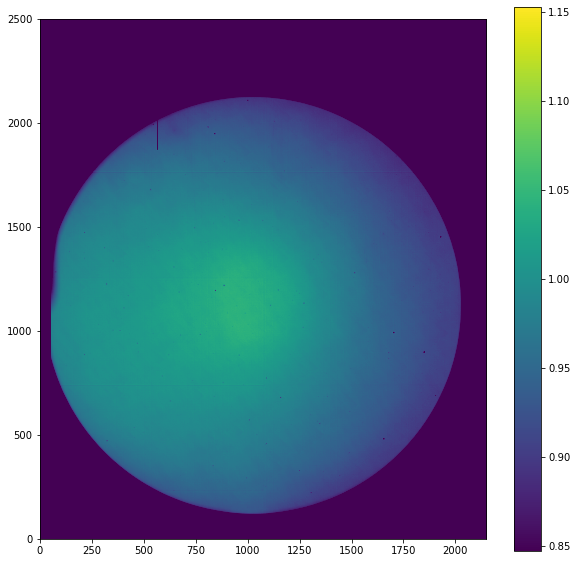

In [17]:
## EXERCISE 5: Median-combine the flat field layer array into a master flat and display it.

# Create the master bias frame by doing a median combination for each pixel over all layers
masterFlat = np.median(flatImages, axis=2)

mean, median, std = sigma_clipped_stats(masterFlat[500:1600,500:1600]) # get some image statistics
print(mean, median, std)

plt.figure(figsize=(10,10))                     # set up the plot panel
plt.imshow(masterFlat, vmin=median-5*std, vmax=median+5*std, origin='lower')
plt.colorbar()
plt.show()


### Flag unexposed pixels

Note that a large fraction of the above image has no signal at all, as you can easily check by changing the scaling above to e.g. vmin=0, vmax=1.1.  Dividing no-signal values by very low flat-field values will fill the unexposed part of the detector with garbage values, which isn't desirable.   Instead, we will set all the low pixel values to NaN ("not a number"), which signifies that these pixels have no scientific value.  These NaN values will propogate to the science images after flat-field division and flag the unwanted pixels in those as well.

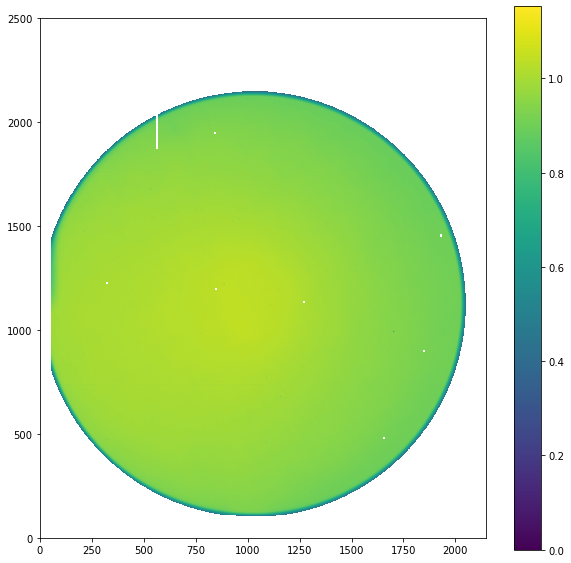

In [18]:
## Set the unexposed pixels to NaN, and display again

masterFlatFixed = np.copy(masterFlat) # Use 'copy' to preserve the original masterFlat
if np.any(masterFlat < 0.2):
        # Set all flat-field values lower than 0.2 to NaN
        masterFlatFixed[masterFlat < 0.2] = float('NaN') 

plt.figure(figsize=(10,10))
#scale the image according to its statistics
plt.imshow(masterFlatFixed, vmin = 0, vmax = median + 5*std, origin='lower')
plt.colorbar()
plt.show()

At this point, we have the necessary calibration images to reduce science images and visualize the true brightness distribution on the sky.  Remember that the observed intensity on the detector is:

$I(x,y) = F(x,y) \,  S(x,y) + B(x,y)$

We now have to retrieve $S(x,y)$ from $I(x,y)$, by inverting this equation, i.e.:

$S(x,y) = \frac{I(x,y)-B(x,y)}{F(x,y)}$

## Pre-processing science frames

Now we will apply the bias flat calibrations to the science frames and write processed science frames to disk for further processing.  To simplify matters, we will write these processed files in 'simple' FITS format, combining the primary header data with the (bias- and flat-corrected) image data in the FITS extension for each file.

In [19]:
## Bias subtract and flat-field all science frames and write out pre-processed files.

numSciFiles = len(sciList)
print('Found %d science files'%numSciFiles)

for i in range(numSciFiles):
        # Read in the FITS data.
        HDUList = fits.open(sciList[i])
        primaryHeader = HDUList[0].header
        imageData = HDUList[1].data    
        HDUList.close()
        
        # Correct for the bias and flats here
        procData = (imageData - masterBias) / masterFlatFixed
        
        # Prepare the output FITS structure in simple format
        procHDU = fits.PrimaryHDU(procData)  # Create a new HDU with the processed image data
        procHDU.header = primaryHeader       # Copy over the header from the raw file
        procHDU.header.add_history('Bias corrected and flat-fielded') # Add a note to the header

        # Write the reduced frame to disk
        print(sciList[i],'->',procList[i])
        procHDU.writeto(procList[i], overwrite=True)
        

Found 3 science files
/home/dperley/growth/image_reduction/data/science/acam761.fits -> /home/dperley/growth/image_reduction/processing/acam761.proc.fits
/home/dperley/growth/image_reduction/data/science/acam762.fits -> /home/dperley/growth/image_reduction/processing/acam762.proc.fits
/home/dperley/growth/image_reduction/data/science/acam763.fits -> /home/dperley/growth/image_reduction/processing/acam763.proc.fits


Now loop through the processed science images we just wrote to the disk and plot them to see what they look like.

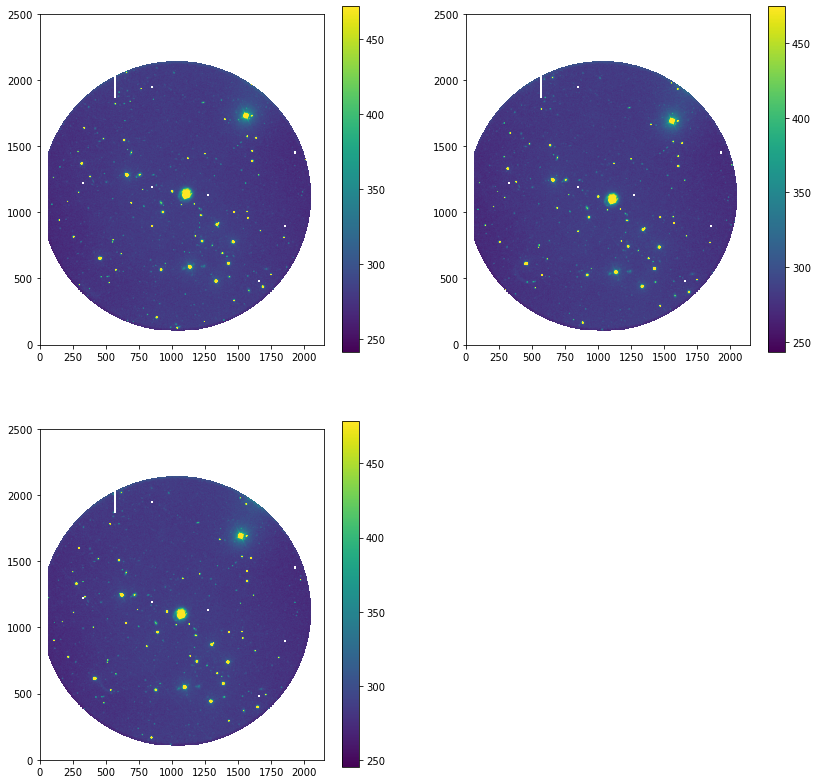

In [20]:
# Inspect the processed science files

plt.figure(figsize=(14,14))
for i in range(numSciFiles):
        procHDU = fits.open(procList[i])
        procData = procHDU[0].data
        procHDU.close()
        
        mean, median, std = sigma_clipped_stats(procData)
        plt.subplot(2,2,1+i)
        plt.imshow(procData, vmin = median - 2*std, vmax = median + 10*std, origin='lower')
        plt.colorbar()


These images are suitable for some types of scientific analysis.  However, we would also like to combine all three together to remove cosmic rays and reduce the noise (go deeper).  This is not as simple as combining the biases or the flats: the images were dithered (the telescope was moved between each exposure) so the astronomical sources lie at different pixel positions in different images.  We will have to align the images relative to each other before stacking.

## Relative astrometric aligment

Aligning images is a form of astrometry (the measurement of precise positions of objects on the sky).  We will worry about absolute astrometry versus the all-sky RA, DEC reference system later, but we do need a way to measure and remove the relative offsets between images now.  If our image-to-image dithering motions are small, the telescope field of view does not contain significant distortions, and the instrument was not rotated, we can do this ourselves in Python by measuring the relative positions of a reference star from image to image and offsetting.

### Measure reference star locations

The first step is to find a nice reference star near the center of the image.  By measuring its centroid as it shifts between all three images, we can calculate how much to offset each image to line them up with each other.  Fortunately there is an excellent, nonsaturated star just to the left of the bright galaxy that's well-suited for this purpose.  Its approximate positions (x,y) in the three science images, estimated by eye, are (998,1161), (998,1121), and (958,1121) respectively.  But it would be better to measure the position more precisely, so the below loop takes a little cutout around our rough position in each image, calculates the centroid, and stores that in a separate list.

In [21]:
## Measure the precise position of a star in each image

# Set the approximate star coordinates
estimated_star_x = [998,998,958]
estimated_star_y = [1161,1121,1121]
actual_star_x = [0,0,0] # dummy values
actual_star_y = [0,0,0]

for i in range(numSciFiles):
        HDUList = fits.open(procList[i])
        procData = HDUList[0].data
        HDUList.close()
        (x0, x1) = (estimated_star_x[i]-20, estimated_star_x[i]+20)
        (y0, y1) = (estimated_star_y[i]-20, estimated_star_y[i]+20)
        cutout = procData[y0:y1,x0:x1]
        mean, median, std = sigma_clipped_stats(cutout)
        cx, cy = photutils.centroid_com(cutout-median)
        actual_star_x[i] = cx+x0
        actual_star_y[i] = cy+y0
        print('Image', i, ':', actual_star_x[i], actual_star_y[i])
        

Image 0 : 995.9951241518626 1160.5778416237783
Image 1 : 996.5207871293705 1121.4444226495268
Image 2 : 956.9765288711183 1121.744590116334


### Apply offsets and crop/shift images

Next we apply these offsets to the image.  In the general case (e.g. if rotations are involved or if the pixel offsets are not pure integers), this involves resampling the image along a new coordinate grid.  To keep things simple, we are just going to apply a simple integer offset by taking appropriately matching slices of each array.  The first image will be cropped from y=150:2150 and x=150:2015 (2000 pixels on each axis).  The other two images will be cropped similarly but with the x and y starting and ending values changed as needed based on their offset.

While we're at it, we also subtract the sky background: because the sky level can vary, it's important to remove it prior to stacking the images.

Image 0 offset: 0 0
Image 1 offset: 1 -39
Image 2 offset: -39 -39


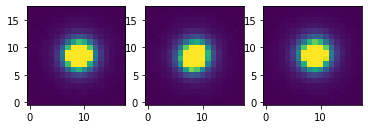

In [22]:
## Offset each image by subsetting to line them up with each other, and subtract the sky

# Define the default crop region and set up the 3D array
xmin = 50
xmax = 2050
ymin = 150
ymax = 2150       
alignedImages = np.zeros((ymax-ymin,xmax-xmin, numSciFiles))

# Calculate and apply offsets, and load the 3D array with appropriately shifted data
for i in range(numSciFiles):
        # Calculate the offset relative to the reference image
        xoffset = int(round(actual_star_x[i]-actual_star_x[0]))
        yoffset = int(round(actual_star_y[i]-actual_star_y[0]))
        print('Image', i, 'offset:', xoffset, yoffset)

        # Open the FITS file and get the data
        HDUList = fits.open(procList[i])        
        procData = HDUList[0].data
        HDUList.close()
        
        # Crop the data appropriately to match up with the reference image
        shiftData = procData[ymin+yoffset:ymax+yoffset, (xmin+xoffset):(xmax+xoffset)]
        shiftData -= np.nanmedian(shiftData) # Subtract sky
        alignedImages[:,:,i] = shiftData     # Add this layer to the 3D array
        
# Verify the images are aligned by plotting a little cutout around where the star should be
for i in range(numSciFiles):
        plt.subplot(1,3,1+i)
        (starX, starY) = (int(round(actual_star_x[0]-xmin)), int(round(actual_star_y[0]-ymin)))
        starCutout = alignedImages[starY-9:starY+9,starX-9:starX+9,i]
        plt.imshow(starCutout, vmin = 0, vmax = 10000, origin='lower')        
        


The star is now in the same place (same pixels) on all three images, so that's good.

### Median-combine science images

During the third and last <font color='red'>breakout segment</font>, you will median-combine the aligned images together (in case you haven't noticed, optical astronomers are really into medians).  Note that while we have subtracted the sky, we have not scaled the data, so we are assuming all three images have the same exposure time and very similar sky conditions (no clouds).  In variable seeing or transparency a median combination will produce strange results!

#### EXERCISE 6: Median-combine the shifted/cropped science images and save the result to disk.   For the output filename, use the string stored in combinedFile.  (Hint: use nanmedian for the stack, and re-use code from when the processed files were written to disk)

In [23]:
## EXERCISE 6: Median-combine the shifted/cropped science images and save the result to disk.

combinedImage = np.nanmedian(alignedImages, axis=2)

HDUList = fits.open(procList[0])
primaryHeader = HDUList[0].header
HDUList.close()

# Prepare the output FITS structure in simple format
combinedHDU = fits.PrimaryHDU(combinedImage)  # Create a new HDU with the processed image data
combinedHDU.header = primaryHeader            # Copy over the header from the (first) raw file
combinedHDU.header.add_history('Median-combined three science frames') # Add a note to the header
combinedHDU.writeto(combinedFile, overwrite=True)


If this worked correctly and you wrote the file out to the path given in the combinedFile variable, the code below should display it for you:

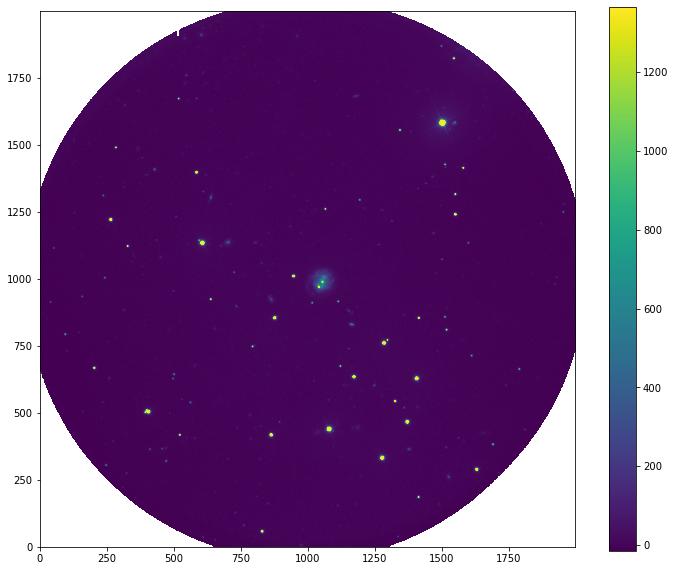

In [24]:
## Confirm the stack worked correctly by reloading the combined image from disk and displaying it.

HDUList = fits.open(combinedFile) # Open the first science file in order to retrieve its header
combinedImage = HDUList[0].data
HDUList.close()

plt.figure(figsize = (12,10))
mean, median, std = sigma_clipped_stats(combinedImage)
plt.imshow(combinedImage, vmin = median - 1*std, vmax = median + 100*std, origin='lower')
plt.colorbar()
plt.show()


At this point you should see an image of the field similar to the one that we displayed during the "Examine the Data" step, but the pixel level of the background sky should be close to zero and you should not be able to discern any artifacts away from the edge of the field of view.  <font color='red'>*If this is the case, you can return from the breakout room.*</font>

## Absolute astrometric calibration

We now have a combined, science-ready image... sort of.  In reality, doing any sort of scientific analysis on this image as it stands will be a big pain, because it doesn't contain any positional information.  If we wanted to extract information about a particular star or galaxy, or (worse) a whole list of objects, this would be extremely frustrating: we would have to scan the image by eye to find each object, write down its pixel coordinates, and send them one-by-one to our photometry or other analysis code.

Fortunately, the FITS format can encode astrometric (positional) information via the header, enabling us to transform (x,y) to (RA,Dec) and back again for any location in the image.  Basic header keywords encode the position, pixel scale, and rotation of the image (plus the spherical projection to be used); these are fully standardized and supported by nearly all astronomical software.  Additional keywords provide distortion terms to allow for deviations from perfectly rectilinear CCD/optics, although unfortunately there are several conflicting conventions for treating distortions and there is no guarantee that your software will support them correctly.

Solving astrometry requires matching a group of stars detected in your image to the stars in the catalog, and solving (fitting) for the parameters in the system of astrometric equations that relate pixel coordinates (x,y) to world coordinates (RA,Dec).  Doing this by hand is painstaking so we will rely on a general-purpose python script that pattern-matches groups of stars in the image to stars in sky catalogs, solves for the astrometric parameters, and writes them to the header.  This process is entirely automated: all we have to give the code is the pixel scale (the projected "size" of each pixel in arcseconds), which for WHT/ACAM is 0.253.

The code requires SourceExtractor (aka SExtractor), an external piece of software that automatically detects and measures the properties of all star-like objects in the image.  Note that you may have to modify the "autoastrometry3.py" file if this is called in an unusual way from your operating system.

In [25]:
## Astrometrically calibrate the reduced image using an external python script

autoastrometry_script = os.path.join(dataFolder, 'autoastrometry3.py')
os.chdir(procFolder)
sextractorCommand = 'sextractor' # Change this if you get an error below

try:
    #Run the autoastrometry script using 2MASS as the reference catalog by specifying 'tmc' with the '-c' option
    astromFile = combinedFile.replace('.fits','.astrom.fits')
    command = 'python3 %s %s -c sdss -px 0.253 -inv -o %s -sex %s -1' % (autoastrometry_script, combinedFile, astromFile, sextractorCommand)
    print('Executing command: %s' % command)
    print('Processing...')
    rval = subprocess.run(command.split(), check=True, capture_output=True)
    print('Process completed.')
    print(rval.stdout.decode())
except subprocess.CalledProcessError as err:
    print('Could not run autoastrometry with error %s. Check if file exists.'%err)
    
os.chdir(curpath) 

Executing command: python3 /home/dperley/growth/image_reduction/data/autoastrometry3.py /home/dperley/growth/image_reduction/processing/AT2018cow_combined.fits -c sdss -px 0.253 -inv -o /home/dperley/growth/image_reduction/processing/AT2018cow_combined.astrom.fits -sex sextractor -1
Processing...
Process completed.
Removed nonstandard WCS keywords:  RADECSYS 
Initial WCS info:
   pixel scale:     x=0.2530"/pix,   y=0.2530"/pix
   position angle: PA=0.00
   inverse parity
   center:        RA=244.000937, dec=22.268017
Refined min FWHM: 2.58 pix
310 objects detected in image (3 discarded)
Source density of 4.3165804 /arcmin^2
2009 good catalog objects.
Source density of 7.0618984 /arcmin^2
Image and/or catalog still too deep.  Trimming...
After trimming: 
    123 detected objects (1.74/arcmin^2, 17.7/searchzone)
    413 catalog objects (1.48/arcmin^2, 15.0/searchzone)
Pair comparison search radius: 107.90"
Using reqmatch = 4
Too many matches: increasing reqmatch to 5
Found 17 candidate m

If this worked you should see a list of successful matches followed by information about the applied rotation and spatial offset.  To make sure the astrometric solution is correct, we can load the star positions (in world coordinates, i.e. RA/Dec) on top of our image:

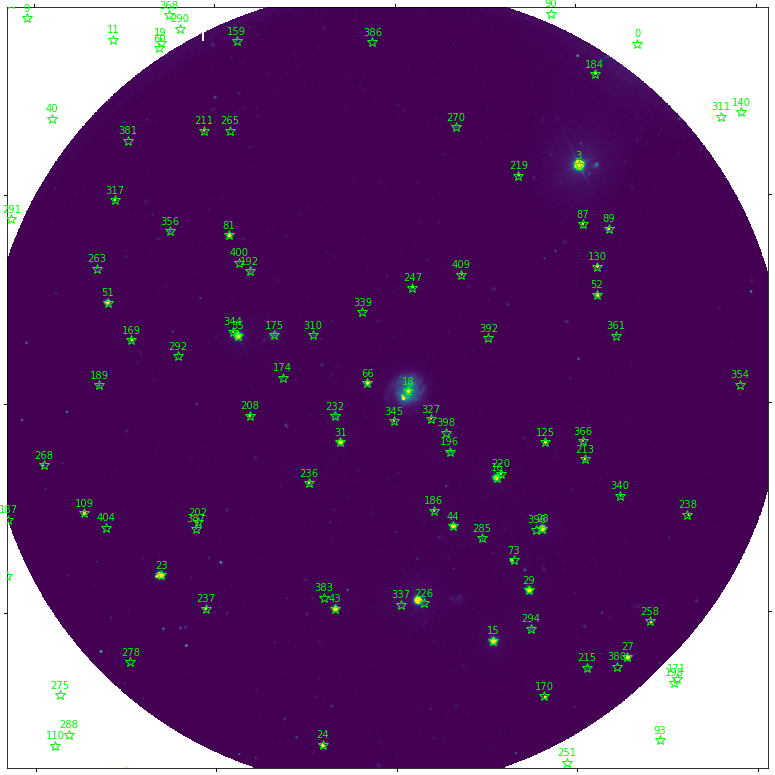

In [26]:
## Display astrometrically calibrated image with star catalog overlaid

# Open the file and get the info
HDUList = fits.open(astromFile)
header = HDUList[0].header
combinedImage = HDUList[0].data
HDUList.close()

# Display the image, associating the WCS information with the axes
wcs = WCS(header)
fig = plt.figure(figsize=(14,14))
ax = plt.subplot(projection=wcs)
plt.imshow(combinedImage, vmin=0, vmax=1000, origin="lower")

# Load star catalog region file
regionFile = os.path.join(procFolder,'cat.wcs.reg')
r = pyregion.open(regionFile).as_imagecoord(header=header)
patch_list, artist_list = r.get_mpl_patches_texts()

# Overlay the star catalog on the plot
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)
plt.show()

Most of the catalog star positions should land on top of bright stars in the image, indicating that our image is correctly aligned to at least a reasonable approximation.  Small deviations may be due to proper motions (stars move!) and catalog errors, or due to distortions in our image field that we have not tried to solve for.

Despite the lack of distortion solution, this should be good enough to find any star or object in the field automatically given its coordinates.  Also, once an image is approximately aligned applying further corrections (using more sophisticated software like scamp) is much easier.

You can load this image in DS9 or other viewing software to interactively explore it in more detail.

## Resampling

The above image does not have North up and East to the left, the normal convention for displaying astronomical images.  The easiest way to project an image to the standard reference system is to resample it using SWarp, another piece of external code.  This can be done as follows:

In [27]:
## Resample the image to standard orientation using SWarp

swarpConfigFile = os.path.join(dataFolder, 'stack.swarp')
swarpCommand = 'SWarp' # Change this if you get an error below

try:
    #IMAGEOUT_NAME is the output stacked file, RESAMPLE_DIR is the directory where the resampled images are to be stored

    command = '%s %s -c %s -IMAGEOUT_NAME %s -WEIGHTOUT_NAME %s -RESAMPLE_DIR %s' % (swarpCommand, astromFile, swarpConfigFile, resampledFile, weightFile, procFolder)
    print("Executing command: %s" % command)
    print("Processing...")
    rval = subprocess.run(command.split(), check=True, capture_output=True)
    print("Process completed.")
    print(rval.stdout.decode())
except subprocess.CalledProcessError as err:
    print('Could not run SWarp. Can you run it from the terminal?')



Executing command: SWarp /home/dperley/growth/image_reduction/processing/AT2018cow_combined.astrom.fits -c /home/dperley/growth/image_reduction/data/stack.swarp -IMAGEOUT_NAME /home/dperley/growth/image_reduction/processing/AT2018cow_resampled.fits -WEIGHTOUT_NAME /home/dperley/growth/image_reduction/processing/AT2018cow_weight.fits -RESAMPLE_DIR /home/dperley/growth/image_reduction/processing
Processing...
Process completed.



This can then be displayed as normal:

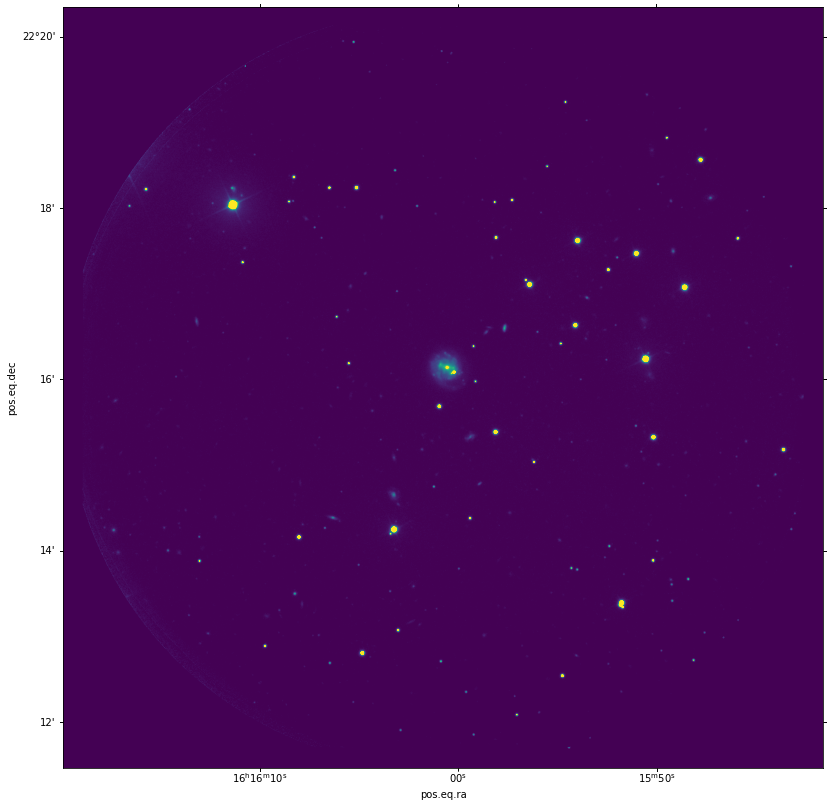

In [28]:
## Display the resampled image

HDUList = fits.open(resampledFile)
wcs = WCS(HDUList[0].header)
resampledData = HDUList[0].data
HDUList.close()

fig = plt.figure(figsize=(14,14))
ax = plt.subplot(projection=wcs)
plt.imshow(resampledData, vmin=0., vmax=1000, origin="lower")


Note that SWarp has set the NaN values to zero, which is somewhat problematic: we may want to change these in software in the future before doing any analysis.  The noise properties have also been changed by the resampling/interpolation.

SWarp also supports resampling a series of (astrometrically-corrected) images onto a common grid and median-stacking them to produce a combined file: simply give it a list of files instead of a single file.  If you have extra time, you can try to produce a stacked image using an this method instead of our Python-based method: astrometrically calibrate the three individual images (with autoastrometry.py) and stack them (with SWarp).  This can be done entirely from the UNIX command line outside of the notebook if you prefer.

## Concluding remarks

At this point, we're done!  Either of the above images could be used for photometry or for other forms of image analysis that will you learn about in the next session.

It is important to note that procedures may differ from telescope to telescope and depending on the type of analysis you're interested in.  Depending on your detector, filter passband, the number of exposures, the time-variability of your source, whether the moon is up or down, whether clouds were present, and the specifications of the type of science you need to do, you may need to carry out additional steps or different steps, such as:

* Overscan subtraction
* Dark current subtraction
* Bad pixel masking
* Source masking in sky flat construction
* Super-sky flat construction and subtraction
* Linearity correction
* Fringe correction or subtraction
* Median-filtered or model-based sky subtraction
* Dithered-group sky subtraction
* Cosmic ray filtering/masking
* Photometric scaling of individual exposures
* Astrometric distortion corrections

### Cleanup

To save disk space, you can execute the cell below to remove your processed data.

In [29]:
# WARNING: WILL REMOVE YOUR PROCESSED DATA FROM THIS NOTEBOOK
os.chdir(curpath)
for f in os.listdir(procFolder):
    try:
        os.remove(os.path.join(procFolder,f)) # clear the processing folder from previous iterations
    except:
        print('Could not remove',f)